### This is Part 3 of 3 part series:

Use the following to navigate

- [Part 1: data processing](01_processing.ipynb)
- [Part 2: data preparation](02_preparation.ipynb)
- [Part 3: model training](03_training.ipynb)

-----

### 6. Model Training

We used the Theano Python deep learning library http://deeplearning.net/software/theano/

In [1]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

import timeit
import sys
import pandas as pd
import numpy as np
import theano
import theano.tensor as T
from six.moves import cPickle

from transptrb.models import MultiLayerRegression
from transptrb.optimizers import SGD, Nadam

/home/melvin/.local/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7301 on context None
Mapped name None to device cuda: GeForce GTX 970M (0000:01:00.0)


1. Define a function to load the processed dataset into the program

In [ ]:
def load_data():
    # read csv files using pandas
    train_x = pd.read_csv('train_x.csv', index_col=0)
    train_y = pd.read_csv('train_y.csv', index_col=0)
    
    valid_x = pd.read_csv('valid_x.csv', index_col=0)
    valid_y = pd.read_csv('valid_y.csv', index_col=0)
    
    test_x = pd.read_csv('test_x.csv', index_col=0)
    test_y = pd.read_csv('test_y.csv', index_col=0)
    
    # verify data structure !optional
    assert (train_y.shape[1] == valid_y.shape[1]) 
    assert (train_x.shape[0] == train_y.shape[0])
    assert (valid_x.shape[0] == valid_y.shape[0])
    assert (test_x.shape[0] == test_y.shape[0])

    train_set = (train_x, train_y)
    valid_set = (valid_x, valid_y)
    test_set = (test_x, test_y)
    
    return train_set, valid_set, test_set

In [ ]:
# load datasets
datasets = load_data()

In [ ]:
# define the model hyperparameters
batch_size  = 4
n_layers = 19
n_hidden_sizes = [64 for i in range(n_layers)] + [128]

train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

n_train_batches = train_set_x.shape[0] // batch_size
n_valid_batches = valid_set_x.shape[0] // batch_size
n_test_batches = test_set_x.shape[0] // batch_size

n_in = test_set_x.shape[1]
n_out = test_set_y.shape[1]

print('number of batches: (train={0:d}, valid={1:d}, test={2:d}), batch size: {3:d}'.format(
    n_train_batches, n_valid_batches, n_test_batches, batch_size))
print('model size: (input={0:d}, output={1:d})'.format(n_in, n_out))
print('layers: {}'.format(n_hidden_sizes))

number of batches: (train=3258, valid=30, test=54), batch size: 4
model size: (input=1024, output=2)
layers: [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 128]


2. Construct the model: using our package transptrb, we load up our model 'MultiLayerRegression'. For optimizers we can choose between SGD or Nadam

In [ ]:
print('... building the model')
x = T.matrix('x')                         # data
y = T.matrix('y')                         # output
is_train = T.iscalar('is_train')          # flags
learning_rate = T.scalar('learning_rate') # tunable learning rate

# define the model file
model = MultiLayerRegression(
    input=x,
    output=y,
    n_in=n_in,
    n_hidden_sizes=n_hidden_sizes,
    n_out=n_out,
    optimizer=Nadam,
    is_train=is_train,
    learning_rate=learning_rate,
    dropout=None,
    resnet=True
)

# compiling a Theano function that computes the RMSE that are made by
# the model on a batch
model.test = theano.function(inputs=[x], 
                             outputs=model.regression_layer.output, 
                             givens={is_train: T.cast(0, 'int32')})

model.validate = theano.function(inputs=[x, y],
                                 outputs=model.errors,  # RMSE
                                 givens={is_train: T.cast(0, 'int32')})

model.train = theano.function(inputs=[x, y, learning_rate],
                              outputs=model.cost,  # MSE
                              updates=model.updates,
                              givens={is_train: T.cast(1, 'int32')})
print('...build complete.')

... building the model
...build complete.


3. Algorithm to train the model. Once the model has reached optimum validation error, it uses the test dataset to predict a set of speed values (North and South)

In [ ]:
print('... training the model')

n_epochs = 200
patience = 20000
patience_increase = 2
threshold = 0.995
validation_freq = min(n_train_batches, patience // 2)

init_lr = 0.0002
decay = 0.05

best_validation_error = np.inf
best_training_cost = np.inf
done_looping = False
epoch = 0

start_time = timeit.default_timer()

# shuffle training set
train_set_x = train_set_x.sample(frac=1.0, random_state=2468)
train_set_y = train_set_y.loc[train_set_x.index]

while (epoch < n_epochs) and (not done_looping):
    # decay learning rate
    epoch_lr = init_lr * ((1. - decay) ** epoch)
    train_cost = []
    
    for n in range(n_train_batches):
        batch_train_x = train_set_x.iloc[
            n * batch_size: (n + 1) * batch_size].values.astype(theano.config.floatX)
        batch_train_y = train_set_y.iloc[
            n * batch_size: (n + 1) * batch_size].values.astype(theano.config.floatX)
        
        # train model using input dataset
        batch_train_cost = model.train(batch_train_x, batch_train_y, epoch_lr)
        train_cost.append(batch_train_cost)

        iteration = epoch * n_train_batches + n
        valid_error = []
        
        # validate model on validation dataset
        if (iteration + 1) % validation_freq == 0:
            for v in range(n_valid_batches):
                batch_valid_x = valid_set_x.iloc[
                    v * batch_size: (v + 1) * batch_size].values.astype(theano.config.floatX)
                batch_valid_y = valid_set_y.iloc[
                    v * batch_size: (v + 1) * batch_size].values.astype(theano.config.floatX)
                batch_valid_error = model.validate(batch_valid_x, batch_valid_y)
                valid_error.append(batch_valid_error)
            
            valid_error = np.mean(valid_error, axis=0)

            print(
                'epoch {0:d}, batch {1:d}/{2:d}, learning rate: {3:.2E}, time elapsed: {6:.2f} mins\n'
                'training error: {4:.3f}, validation error: {5}\n'.format(
                epoch+1, n+1, n_train_batches, epoch_lr, np.sqrt(np.mean(train_cost)), valid_error,
                (timeit.default_timer()-start_time)/60.)
            )

            valid_error = np.mean(valid_error)
            if valid_error < best_validation_error:
                if valid_error < best_validation_error * threshold:
                    patience = max(patience, iteration * patience_increase)

                # save model
#                 with open('best_model.save', 'wb') as f:
#                     cPickle.dump(model, f, protocol=cPickle.HIGHEST_PROTOCOL)
                
                # update minimum error
                best_validation_error = valid_error
                best_training_cost = np.sqrt(np.mean(train_cost))
                
                # predict speed
                predictions = pd.DataFrame(
                    data=model.test(test_set_x.values.astype(theano.config.floatX)), 
                    index=test_set_y.index, 
                    columns=['Speed_north_pred', 'Speed_south_pred'])
        
        if (patience <= iteration) & (epoch > 15):
            done_looping = True
            break
    
    # increment epoch count
    epoch = epoch + 1

end_time = timeit.default_timer()
print(
    'Optimization complete with best validation error of {0:.3f}, training cost of {1:.3f}\n'
    'The code ran for {2:d} epochs with {3:.3f} epochs/sec'.format(
    best_validation_error, best_training_cost, epoch, epoch / (end_time-start_time)) 
)

# save results to csv
test_set_y = pd.read_csv('test_y.csv', index_col=0).fillna(0.)
speedtable = pd.read_csv('speedtable_full.csv', index_col=0).fillna(0.)
test_set_y.index = pd.to_datetime(test_set_y.index).tz_localize('UTC').tz_convert('Asia/Shanghai').tz_localize(None)
speedtable.index = pd.to_datetime(speedtable.index).tz_localize('UTC').tz_convert('Asia/Shanghai').tz_localize(None)
predictions.index = test_set_y.index
predictions.loc[
    predictions.index.hour.isin([6,7,8,9,10,16,17,18,19,20])].to_csv(
    'outputs/{0:.2f}_predictions.csv'.format(best_validation_error))

... training the model
epoch 1, batch 3258/3258, learning rate: 2.00E-04, time elapsed: 0.19 mins
training error: 6.259, validation error: [8.41233  8.908086]

epoch 2, batch 3258/3258, learning rate: 1.90E-04, time elapsed: 0.38 mins
training error: 5.855, validation error: [4.6011834 4.792662 ]

epoch 3, batch 3258/3258, learning rate: 1.80E-04, time elapsed: 0.56 mins
training error: 5.318, validation error: [4.3067317 4.7275543]

epoch 4, batch 3258/3258, learning rate: 1.71E-04, time elapsed: 0.75 mins
training error: 5.129, validation error: [4.163102 4.714322]

epoch 5, batch 3258/3258, learning rate: 1.63E-04, time elapsed: 0.93 mins
training error: 5.078, validation error: [4.240717  4.7892838]

epoch 6, batch 3258/3258, learning rate: 1.55E-04, time elapsed: 1.12 mins
training error: 5.006, validation error: [4.1042786 4.8170176]

epoch 7, batch 3258/3258, learning rate: 1.47E-04, time elapsed: 1.30 mins
training error: 4.979, validation error: [3.9317224 4.7527328]

epoch 8,

## 7. Visualize predictions

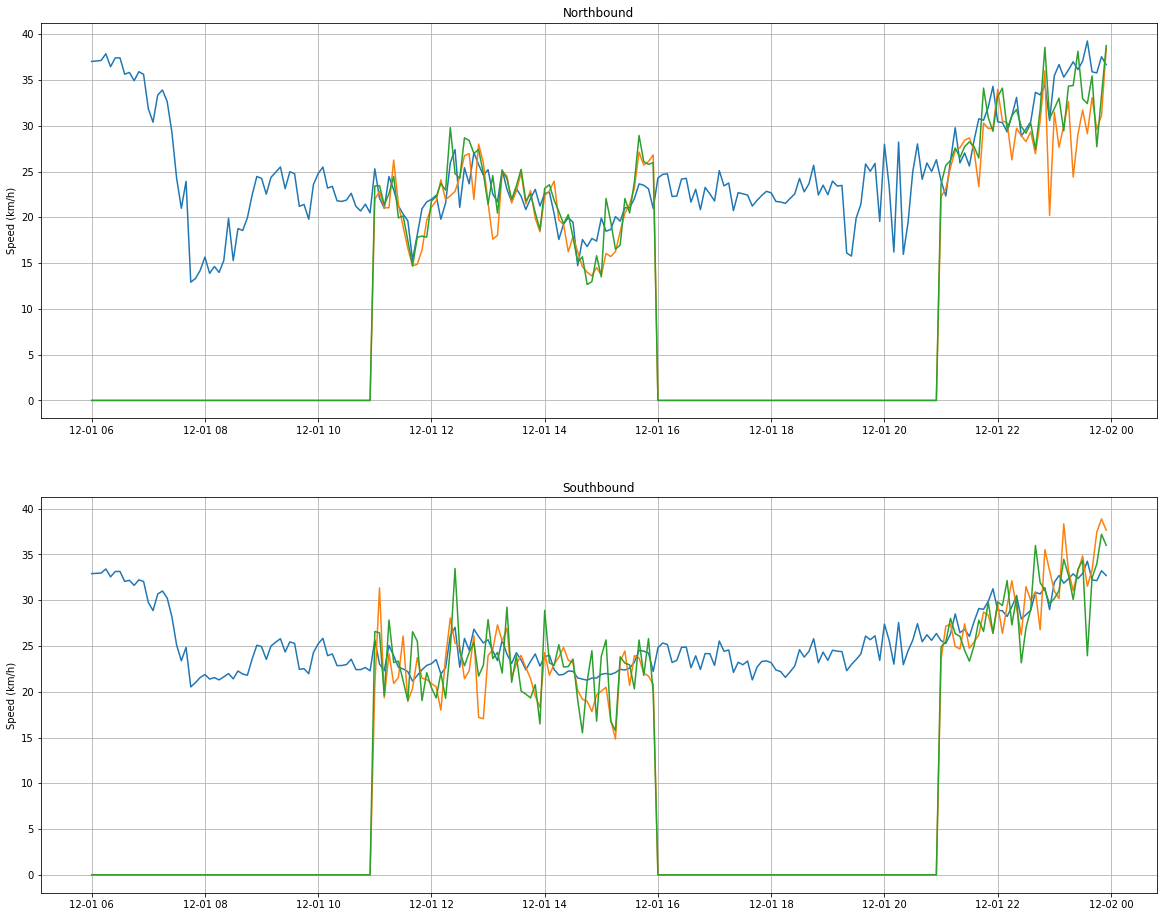

In [8]:
# Trial 10 : 256, 128 64*30; w_resnet
# Optimization complete with best validation error of 3.0839710235595703, training cost of 4.290592670440674
import matplotlib.pyplot as plt
import pytz

fig, ax = plt.subplots(2, 1, figsize=(20, 16), sharey=True)

ax[0].set_title('Northbound')
ax[0].set_ylabel('Speed (km/h)')
ax[0].grid(True)
ax[0].plot(predictions['Speed_north_pred'])
ax[0].plot(test_set_y['Speed_north'])
ax[0].plot(speedtable.loc['2016-12-01 06:00:00+08:00':, 'Speed_north'])

ax[1].set_title('Southbound')
ax[1].set_ylabel('Speed (km/h)')
ax[1].grid(True)
ax[1].plot(predictions['Speed_south_pred'])
ax[1].plot(test_set_y['Speed_south'])
ax[1].plot(speedtable.loc['2016-12-01 06:00:00+08:00':, 'Speed_south'])

fig.show()